In [131]:
library(tidyverse)
library(naniar)
library(visdat)
library(ggplot2)
library(lubridate)
library(gridExtra)
library(GGally)
library(corrr)
library(dplyr)
library(car)
library(mgcv)
library(ggfortify)
library(reshape)

### 1. Initial data load and feature subset/tranform etc. 

In [190]:
data = read.csv('data/fatal-police-shootings-data.csv', na.strings=c("","NA"))
# weather&policeshootings.csv

In [133]:
dim(data)
names(data)

[1] 7291   19

[1] "id"                      "name"                   
 [3] "date"                    "manner_of_death"        
 [5] "armed"                   "age"                    
 [7] "gender"                  "race"                   
 [9] "city"                    "state"                  
[11] "signs_of_mental_illness" "threat_level"           
[13] "flee"                    "body_camera"            
[15] "longitude"               "latitude"               
[17] "is_geocoding_exact"      "smha_exp_per_capita"    
[19] "smi_prevalance"

#### Drop features as necessary

In [134]:
features_to_keep = c("date","armed","age","gender","race","state","flee","body_camera","signs_of_mental_illness")
data = data[, (names(data) %in% features_to_keep)]

#### Convert features to desired datatypes

In [135]:
factor_cols = c("armed", "gender", "race", "state", "flee", "body_camera", "signs_of_mental_illness")
numeric_cols = c("age")

data <- data %>% 
    mutate(across(.cols=all_of(factor_cols), .fns = as.factor))
data <- data %>% 
    mutate(across(.cols=all_of(numeric_cols), .fns = as.numeric))
data <- data %>% 
    mutate(across(.cols="date", .fns = as_date))

#### Transform features as required

In [136]:
# For some reason, this kept throwing an error for me, so I tried another method
data = data %>% 
  mutate(armed = case_when(
    armed == "gun" ~ "gun",
    armed == "knife" ~ "knife",
    armed == "vehicle" ~ "vehicle",
    armed == "unarmed" ~ "unarmed",
    armed == "undetermined" ~ "undetermined",
    TRUE ~ "other",
  )
)

In [137]:
# Race -> Combine A/N/O/NA under O?
data = data %>% 
  mutate(race = case_when(
    race == "W" ~ "W",
    race == "B" ~ "B",
    race == "H" ~ "H",
    TRUE ~ "O",
  )
)
data$race = as.factor(data$race)
summary(data$race)

B    H    O    W 
1595 1089 1584 3023

In [138]:
# Fleeing -> convert NA to 'Missing'
data = data %>% 
  mutate(flee = case_when(
    flee == "Car" ~ "Car",
    flee == "Foot" ~ "Foot",
    flee == "Not fleeing" ~ "Not fleeing",
    flee == "Other" ~ "Other",
    TRUE ~ "Missing",
  )
)
data$flee = as.factor(data$flee)
summary(data$flee)

Car        Foot     Missing Not fleeing       Other 
       1183         943         666        4232         267

### 2. Dealing with missing values

Check missing data frequency for each column

In [139]:
# Percent missing values per column
as.data.frame((colMeans(is.na(data)))*100)

,(colMeans(is.na(data))) * 100
,<dbl>
date,0.0000000
armed,0.0000000
age,5.7742422
gender,0.1371554
race,0.0000000
state,0.0000000
signs_of_mental_illness,0.0000000
flee,0.0000000
body_camera,0.0000000


Check patterns in data missingness

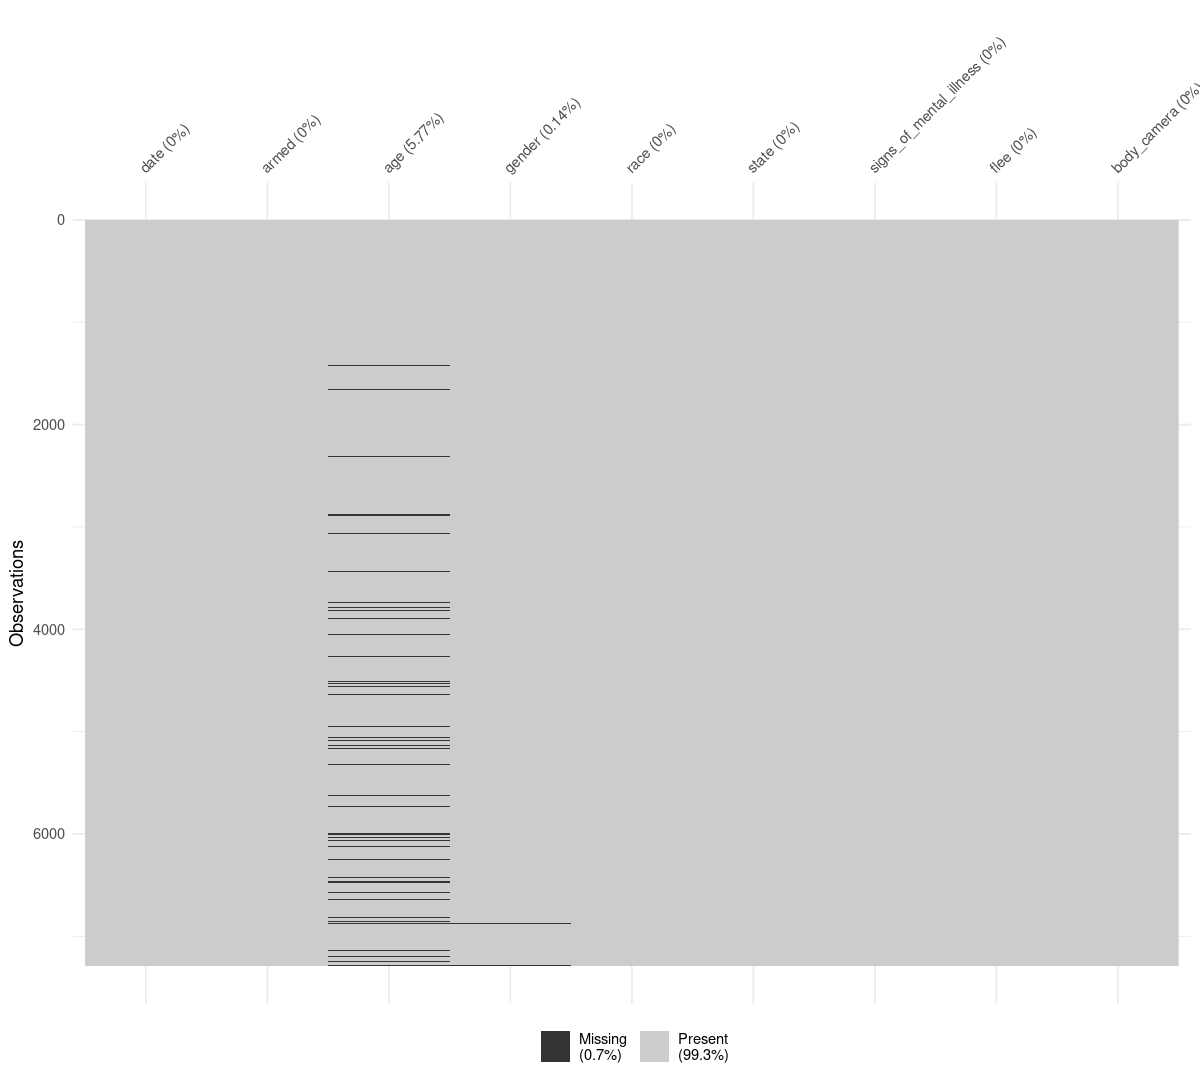

In [140]:
options(repr.plot.width=10, repr.plot.height=9)
vis_miss(data)

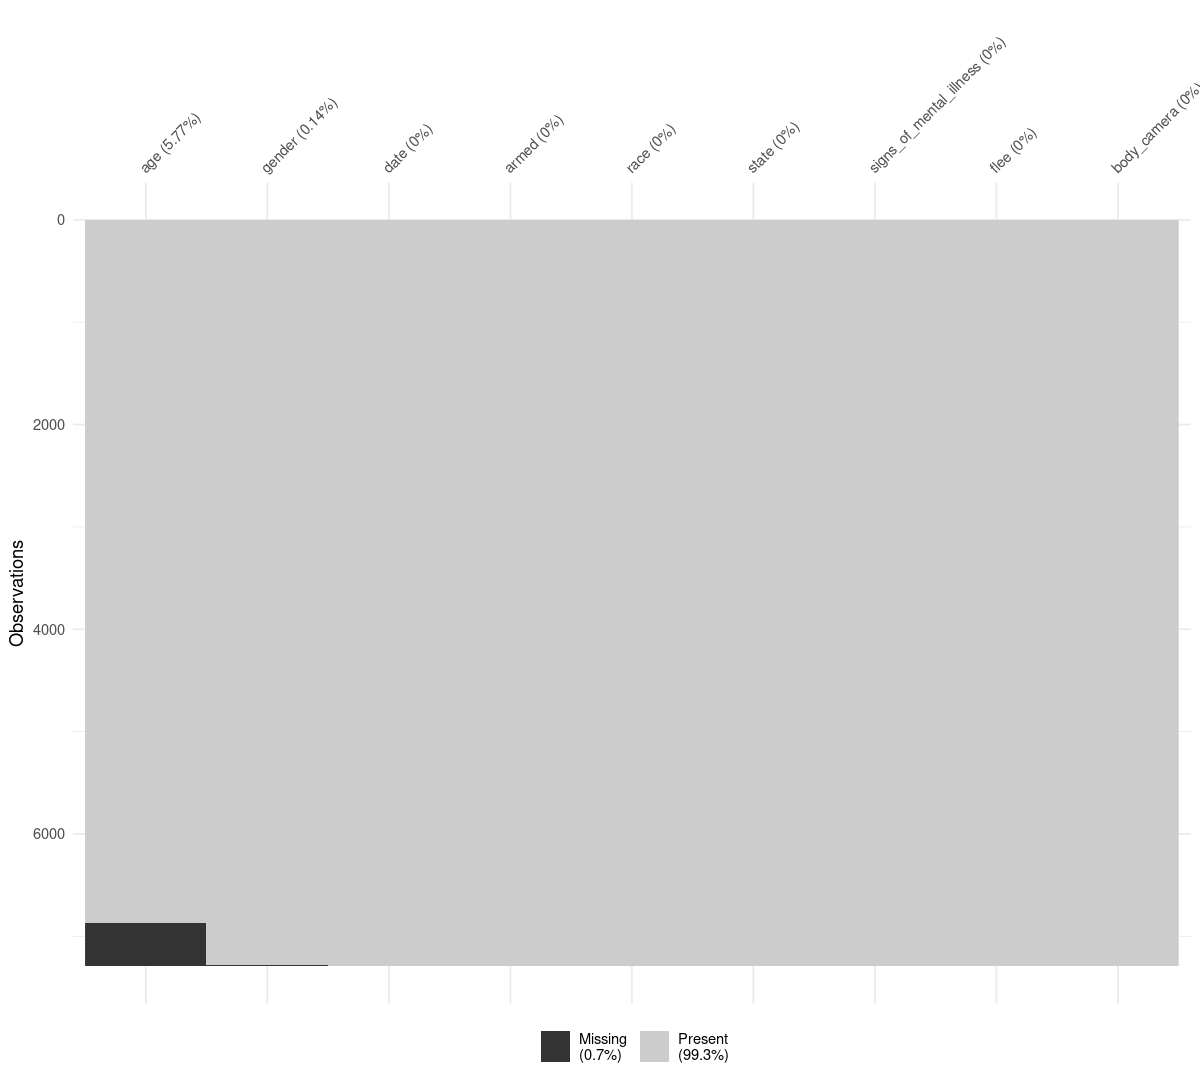

In [98]:
vis_miss(data, cluster = TRUE, sort_miss = TRUE)

In [11]:
summary(data$gender)

F    M NA's 
 330 6951   10

In [141]:
# Drop where gender is NA? The observations are too few in number to add as a category
data = data %>% drop_na(gender)

In [142]:
# Age -> use mean/median imputation?
data$age[is.na(data$age)] <- median(data$age, na.rm = T)

> Missing values have been dealt with, but it would have been a good idea to check if the missingness pattern in age was MCAR/MAR/MNAR

In [143]:
names(data)

[1] "date"                    "armed"                  
[3] "age"                     "gender"                 
[5] "race"                    "state"                  
[7] "signs_of_mental_illness" "flee"                   
[9] "body_camera"

### 3. Evaluation metric & Residual analyses plan

Since this is logistic regression and we are focused on interpretation, it may make sense to look at pure accuracy after using the model weightages as suggested by Alice, to handle the imbalanced nature of the target. Overall, we can consider the following measures:
1. Accuracy
2. AIC
3. AUROC

We should also check that there isn't high linear dependence between the factors using the VIF. `vif(glm.all)`

After models are fitted, check:
1. Histogram of residuals
2. Calibration chart
3. Inspect largest outliers?

### 4. Building model to fit data

In [144]:
library(lme4)
library(splines)

In [145]:
names(data)

[1] "date"                    "armed"                  
[3] "age"                     "gender"                 
[5] "race"                    "state"                  
[7] "signs_of_mental_illness" "flee"                   
[9] "body_camera"

In [146]:
#  1. Run the model selection process on the entire dataset:
#     + start with all features we are considering and build a logistic regression model 
#       (including weights for different classes for outcome, random effects for states, ignoring date etc.)

pos_prop = 1575/(1575 + 5706) # proportion of records where the response variable is positive
neg_prop = 1 - pos_prop
response_weights <- ifelse(data$signs_of_mental_illness == 'True', 1/pos_prop, 1/neg_prop)

In [148]:
model_overall <- glmer(signs_of_mental_illness ~ armed + age + gender + race + flee + body_camera + (1|state), 
                    data=data, family="binomial", weights=response_weights)
summary(model_overall)

Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?”

Correlation matrix not shown by default, as p = 16 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: signs_of_mental_illness ~ 1 + armed + age + gender + race + flee +  
    body_camera + (1 | state)
   Data: data
Weights: response_weights

     AIC      BIC   logLik deviance df.resid 
 17975.7  18092.9  -8970.9  17941.7     7264 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0932 -1.2042 -0.8086 -0.4396  7.7365 

Random effects:
 Groups Name        Variance Std.Dev.
 state  (Intercept) 0.1303   0.3609  
Number of obs: 7281, groups:  state, 51

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -1.390851   0.130910 -10.625  < 2e-16 ***
armedknife         0.641243   0.051171  12.531  < 2e-16 ***
armedother         0.519466   0.050575  10.271  < 2e-16 ***
armedunarmed       0.110407   0.078325   1.410   0.1587    
armedundetermined -0.288672   0.117736  -2.452   0.0142 *  
armedvehicle      -1.0530

In [189]:
# Pasting output from above model here

#      AIC      BIC   logLik deviance df.resid 
#  17975.7  18092.9  -8970.9  17941.7     7264 

# Scaled residuals: 
#     Min      1Q  Median      3Q     Max 
# -3.0932 -1.2042 -0.8086 -0.4396  7.7365 

# Random effects:
#  Groups Name        Variance Std.Dev.
#  state  (Intercept) 0.1303   0.3609  
# Number of obs: 7281, groups:  state, 51

# Fixed effects:
#                    Estimate Std. Error z value Pr(>|z|)    
# (Intercept)       -1.390851   0.130910 -10.625  < 2e-16 ***
# armedknife         0.641243   0.051171  12.531  < 2e-16 ***
# armedother         0.519466   0.050575  10.271  < 2e-16 ***
# armedunarmed       0.110407   0.078325   1.410   0.1587    
# armedundetermined -0.288672   0.117736  -2.452   0.0142 *  
# armedvehicle      -1.053089   0.153687  -6.852 7.27e-12 ***
# age                0.009940   0.001462   6.798 1.06e-11 ***
# genderM           -0.572648   0.085782  -6.676 2.46e-11 ***
# raceH              0.161392   0.067559   2.389   0.0169 *  
# raceO              0.136582   0.060416   2.261   0.0238 *  
# raceW              0.760768   0.051244  14.846  < 2e-16 ***
# fleeFoot           0.324410   0.080943   4.008 6.13e-05 ***
# fleeMissing        0.540870   0.086438   6.257 3.92e-10 ***
# fleeNot fleeing    1.255984   0.061756  20.338  < 2e-16 ***
# fleeOther         -0.013478   0.129814  -0.104   0.9173    
# body_cameraTrue    0.340131   0.051715   6.577 4.80e-11 ***


Interpretation:
1. It appears that being armed is a significant factor in increasing the perception of mental illness in fatal encounters. However, being armed with a vehicle actually decreases the perception. 
2. Age is positively correlated with signs of mental illness, but a year's increase isn't that large a factor
3. Being female signficantly increases the probability that a mental illness is perceived. 
4. The baseline for race is Black. In comparison, other races are more likely to be perceived as being mentally ill, especially White people.
5. The fleeing effect is not clear, except that if a person isn't fleeing, they are much more likely to be perceived as showing signs of mental illness. 
6. The police having a body camera increases the chances of perception of mental illness. 

To consider:
1. We don't have data on police encounters, but only on fatal encounters. It would be instructive to see how police having body cameras come together with perceptions of mental illness in affecting whether an encounter is fatal. 
2. For each feature, the above statement is true. 

In [194]:
# install.packages("glmmLasso")
library(glmmLasso)

In [197]:
# Cannot find a mixed effects lasso model which accepts weights as input
# model_overall_lasso <- glmmLasso(signs_of_mental_illness ~ armed + age + gender + race + flee + body_camera + (1|state), 
#                     data=data, family="binomial", weights=response_weights, lambda=1)
# summary(model_overall_lasso)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



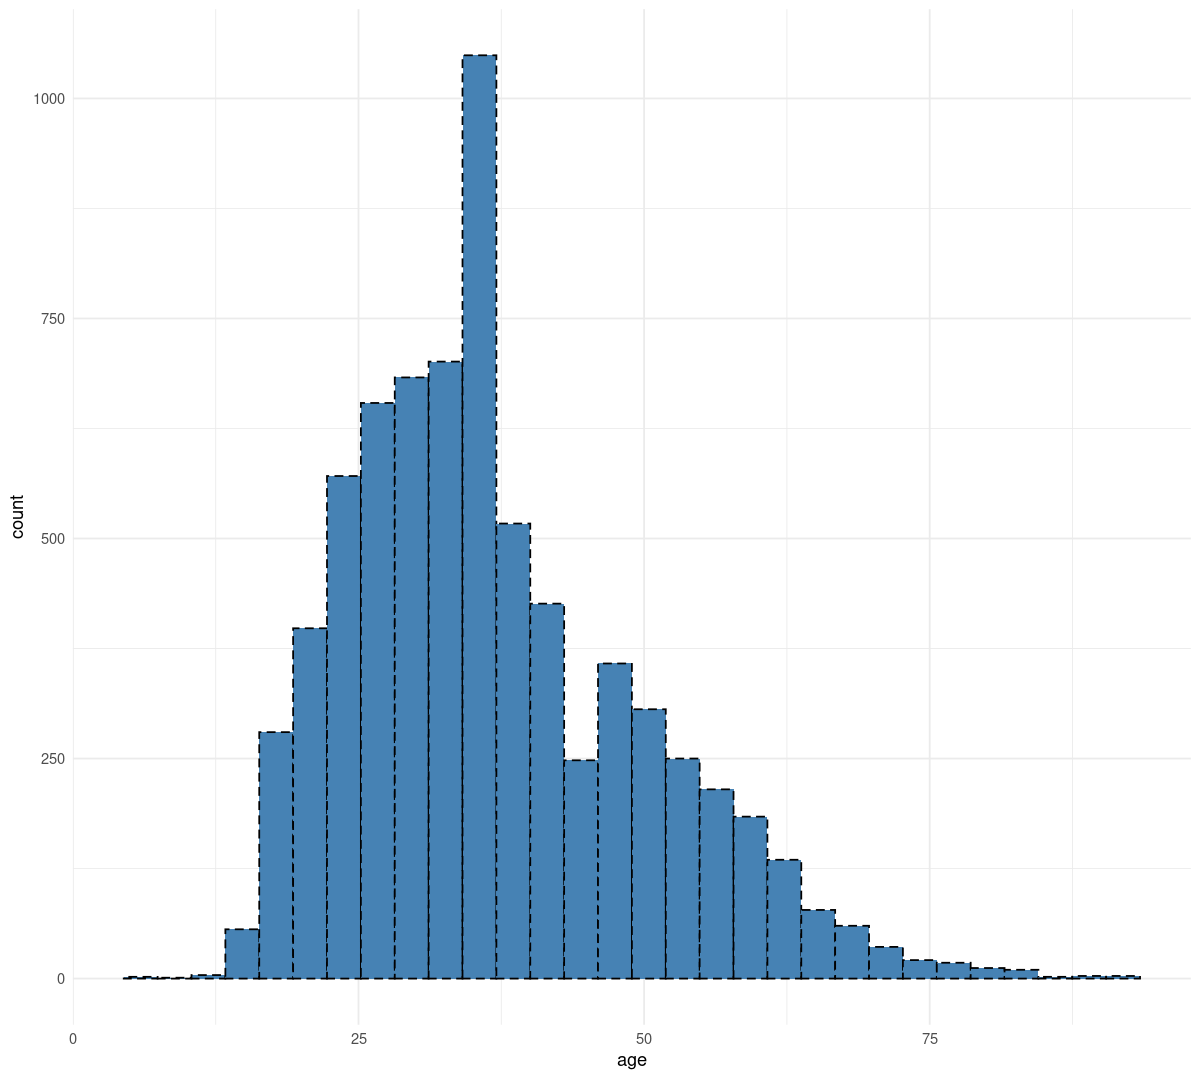

In [19]:
ggplot(data=data, aes(x=age)) + geom_histogram(color="black", fill="steelblue", linetype="dashed") + theme_minimal() + xlab("age")

In [20]:
#     + Experiment with splines and interactions

# Try spline on age
knots.age <- quantile(data$age, c(0.1, 0.3, 0.5, 0.7, 0.9))
model_overall_spline <- glmer(signs_of_mental_illness ~ armed + gender + ns(age, knots=knots.age) + race + flee + body_camera + (1|state), 
                    data=data, family="binomial", weights=response_weights)
summary(model_overall_spline)

Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”

Correlation matrix not shown by default, as p = 21 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
signs_of_mental_illness ~ armed + gender + ns(age, knots = knots.age) +  
    race + flee + body_camera + (1 | state)
   Data: data
Weights: response_weights

     AIC      BIC   logLik deviance df.resid 
 17964.2  18115.9  -8960.1  17920.2     7259 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0451 -1.2039 -0.8087 -0.4375  7.7032 

Random effects:
 Groups Name        Variance Std.Dev.
 state  (Intercept) 0.1318   0.363   
Number of obs: 7281, groups:  state, 51

Fixed effects:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -3.07714    0.60466  -5.089 3.60e-07 ***
armedknife                   0.64550    0.05125  12.596  < 2e-16 ***
armedother                   0.52821    0.05068  10.422  < 2e-16 ***
armedunarmed                 0.12031    0.07847   1.533 0.125216    
armedundetermined   

Adding a spline on age doesn't seem to have brought the AIC down by enough, and the added complexity of interpreting the different interval related coefficient seesm to make it not worth the while of fitting the spline. 

In [21]:
# Consider interactions

# Try gender*race - insignificant features and no AIC improvement
model_overall_inter1 <- glmer(signs_of_mental_illness ~ armed + gender + age + race + flee + body_camera + gender*race + (1|state), 
                    data=data, family="binomial", weights=response_weights)
summary(model_overall_inter1)

# Try age*race - insignificant features and no AIC improvement
model_overall_inter2 <- glmer(signs_of_mental_illness ~ armed + gender + age + race + flee + body_camera + age*race + (1|state), 
                    data=data, family="binomial", weights=response_weights)
summary(model_overall_inter2)

# Try armed*race - a features were significant, but AIC only dropped form 8810 to 8807, so not enough for inclusion
model_overall_inter3 <- glmer(signs_of_mental_illness ~ armed + gender + age + race + flee + body_camera + armed*race + (1|state), 
                    data=data, family="binomial", weights=response_weights)
summary(model_overall_inter3)

# Try flee*race - relatively insignificant features and no AIC improvement
model_overall_inter4 <- glmer(signs_of_mental_illness ~ armed + gender + age + race + flee + body_camera + flee*race + (1|state), 
                    data=data, family="binomial", weights=response_weights)
summary(model_overall_inter4)

# Try body_camera*race - insignificant features and no AIC improvement
model_overall_inter5 <- glmer(signs_of_mental_illness ~ armed + gender + age + race + flee + body_camera + body_camera*race + (1|state), 
                    data=data, family="binomial", weights=response_weights)
summary(model_overall_inter5)

# Try gender*age - insignificant features and no AIC improvement
model_overall_inter6 <- glmer(signs_of_mental_illness ~ armed + gender + age + race + flee + body_camera + gender*age + (1|state), 
                    data=data, family="binomial", weights=response_weights)
summary(model_overall_inter6)

# Try armed*body_camera - relatively insignificant features and no AIC improvement
model_overall_inter7 <- glmer(signs_of_mental_illness ~ armed + gender + age + race + flee + body_camera + armed*body_camera + (1|state), 
                    data=data, family="binomial", weights=response_weights)
summary(model_overall_inter7)

Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00565667 (tol = 0.002, component 1)”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?”

Correlation matrix not shown by default, as p = 19 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: signs_of_mental_illness ~ armed + gender + age + race + flee +  
    body_camera + gender * race + (1 | state)
   Data: data
Weights: response_weights

     AIC      BIC   logLik deviance df.resid 
 17976.5  18114.3  -8968.2  17936.5     7261 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8937 -1.2055 -0.8108 -0.4396  7.7437 

Random effects:
 Groups Name        Variance Std.Dev.
 state  (Intercept) 0.1298   0.3603  
Number of obs: 7281, groups:  state, 51

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -1.225729   0.228453  -5.365 8.08e-08 ***
armedknife         0.638885   0.051213  12.475  < 2e-16 ***
armedother         0.520592   0.050588  10.291  < 2e-16 ***
armedunarmed       0.108497   0.078358   1.385 0.166166    
armedundetermined -0.284751   0.117746  -2.418 0.015591 *  
armedvehicle 

Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.0068239 (tol = 0.002, component 1)”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?”

Correlation matrix not shown by default, as p = 19 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: signs_of_mental_illness ~ armed + gender + age + race + flee +  
    body_camera + age * race + (1 | state)
   Data: data
Weights: response_weights

     AIC      BIC   logLik deviance df.resid 
 17971.9  18109.8  -8966.0  17931.9     7261 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0230 -1.2063 -0.8088 -0.4360  7.8028 

Random effects:
 Groups Name        Variance Std.Dev.
 state  (Intercept) 0.1318   0.3631  
Number of obs: 7281, groups:  state, 51

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -1.468366   0.171853  -8.544  < 2e-16 ***
armedknife         0.636779   0.051313  12.410  < 2e-16 ***
armedother         0.513620   0.050729  10.125  < 2e-16 ***
armedunarmed       0.103333   0.078502   1.316 0.188068    
armedundetermined -0.285374   0.117885  -2.421 0.015487 *  
armedvehicle    

Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00603641 (tol = 0.002, component 1)”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?”

Correlation matrix not shown by default, as p = 31 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: signs_of_mental_illness ~ armed + gender + age + race + flee +  
    body_camera + armed * race + (1 | state)
   Data: data
Weights: response_weights

     AIC      BIC   logLik deviance df.resid 
 17924.8  18145.3  -8930.4  17860.8     7249 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8973 -1.2061 -0.7999 -0.4233  9.6067 

Random effects:
 Groups Name        Variance Std.Dev.
 state  (Intercept) 0.1344   0.3666  
Number of obs: 7281, groups:  state, 51

Fixed effects:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -1.632599   0.136141 -11.992  < 2e-16 ***
armedknife               1.288588   0.119214  10.809  < 2e-16 ***
armedother               1.025604   0.117072   8.760  < 2e-16 ***
armedunarmed             0.673875   0.143045   4.711 2.47e-06 ***
armedundetermined       -0.533047   0.374593

Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?;Model is nearly unidentifiable: large eigenvalue ratio
 - Rescale variables?”

Correlation matrix not shown by default, as p = 28 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: signs_of_mental_illness ~ armed + gender + age + race + flee +  
    body_camera + flee * race + (1 | state)
   Data: data
Weights: response_weights

     AIC      BIC   logLik deviance df.resid 
 17960.7  18160.6  -8951.3  17902.7     7252 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1051 -1.2062 -0.8053 -0.3946  8.7322 

Random effects:
 Groups Name        Variance Std.Dev.
 state  (Intercept) 0.1316   0.3627  
Number of obs: 7281, groups:  state, 51

Fixed effects:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -1.102787   0.167160  -6.597 4.19e-11 ***
armedknife             0.642674   0.051315  12.524  < 2e-16 ***
armedother             0.517264   0.050693  10.204  < 2e-16 ***
armedunarmed           0.109929   0.078315   1.404 0.160417    
armedundetermined     -0.269595   0.118660  -2.272 0.02

Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?”

Correlation matrix not shown by default, as p = 19 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: signs_of_mental_illness ~ armed + gender + age + race + flee +  
    body_camera + body_camera * race + (1 | state)
   Data: data
Weights: response_weights

     AIC      BIC   logLik deviance df.resid 
 17980.2  18118.1  -8970.1  17940.2     7261 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1812 -1.2040 -0.8085 -0.4403  7.7247 

Random effects:
 Groups Name        Variance Std.Dev.
 state  (Intercept) 0.1304   0.3611  
Number of obs: 7281, groups:  state, 51

Fixed effects:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -1.373387   0.131838 -10.417  < 2e-16 ***
armedknife             0.641385   0.051186  12.530  < 2e-16 ***
armedother             0.518505   0.050594  10.248  < 2e-16 ***
armedunarmed           0.109049   0.078366   1.392   0.1641    
armedundetermined     -0.286775   0.117811  -2.4

Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.0259373 (tol = 0.002, component 1)”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?”

Correlation matrix not shown by default, as p = 17 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: signs_of_mental_illness ~ armed + gender + age + race + flee +  
    body_camera + gender * age + (1 | state)
   Data: data
Weights: response_weights

     AIC      BIC   logLik deviance df.resid 
 17973.7  18097.8  -8968.9  17937.7     7263 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4617 -1.2027 -0.8090 -0.4392  7.7525 

Random effects:
 Groups Name        Variance Std.Dev.
 state  (Intercept) 0.1298   0.3602  
Number of obs: 7281, groups:  state, 51

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -1.894585   0.285433  -6.638 3.19e-11 ***
armedknife         0.640795   0.051183  12.520  < 2e-16 ***
armedother         0.519829   0.050577  10.278  < 2e-16 ***
armedunarmed       0.115042   0.078375   1.468 0.142147    
armedundetermined -0.291344   0.117813  -2.473 0.013401 *  
armedvehicle  

Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?”

Correlation matrix not shown by default, as p = 21 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: signs_of_mental_illness ~ armed + gender + age + race + flee +  
    body_camera + armed * body_camera + (1 | state)
   Data: data
Weights: response_weights

     AIC      BIC   logLik deviance df.resid 
 17966.4  18118.0  -8961.2  17922.4     7259 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2008 -1.1961 -0.8108 -0.4408  7.8148 

Random effects:
 Groups Name        Variance Std.Dev.
 state  (Intercept) 0.1323   0.3637  
Number of obs: 7281, groups:  state, 51

Fixed effects:
                                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)                       -1.370576   0.131331 -10.436  < 2e-16 ***
armedknife                         0.596739   0.055684  10.717  < 2e-16 ***
armedother                         0.441695   0.054796   8.061 7.58e-16 ***
armedunarmed                       0.023056   0.088449   0.261 

We're particularly interested in exploring interactions between race and other features, yet find that including no such interactions improve our model. Few created features are significant, and none decrease AIC by a meaningful amount. We see similar results for interactions between gender and age, as well as armed and body camera.

In [22]:
#     + Use the evaluation metrics to settle on a final model that we want to stick with, check VIF

#### As of now, proceeding with the original model w/o splines or interactions

library(InformationValue)

# Accuracy
threshold = 0.5
probs = predict(model_overall, type="response")
pred = ifelse(probs > threshold, 'True', 'False')

accuracy = sum(pred == data$signs_of_mental_illness) / length(pred)
print(accuracy)

# Sensitivity and specificity
t = table(pred, data$signs_of_mental_illness)
sensitivity = t[2,2] / sum(t[,2])
specificity = t[1,1] / sum(t[,1])

t
summary(data$signs_of_mental_illness)

# VIF
vif(model_overall)

[1] 0.6490867


       
pred    False True
  False  3626  475
  True   2080 1100

False  True 
 5706  1575

,GVIF,Df,GVIF^(1/(2*Df))
armed,1.142098,5,1.013375
age,1.086530,1,1.042367
gender,1.024223,1,1.012039
race,1.104925,3,1.016769
flee,1.143649,4,1.016920
body_camera,1.018748,1,1.009330


Using our original model without splines or transformations, we achieve an accuracy of 78.8%. Considering the target variable is 78.4% negative, we're barely beating the baseline accuracy score. Only 115 positives for signs of mental illness are correctly classified, while 1,460 true positives were incorrectly classified as negative. We have a very high specificity (0.985) but very low sensitivity (0.073).

We do not see high linear dependence between features, as all VIFs are close to 1.

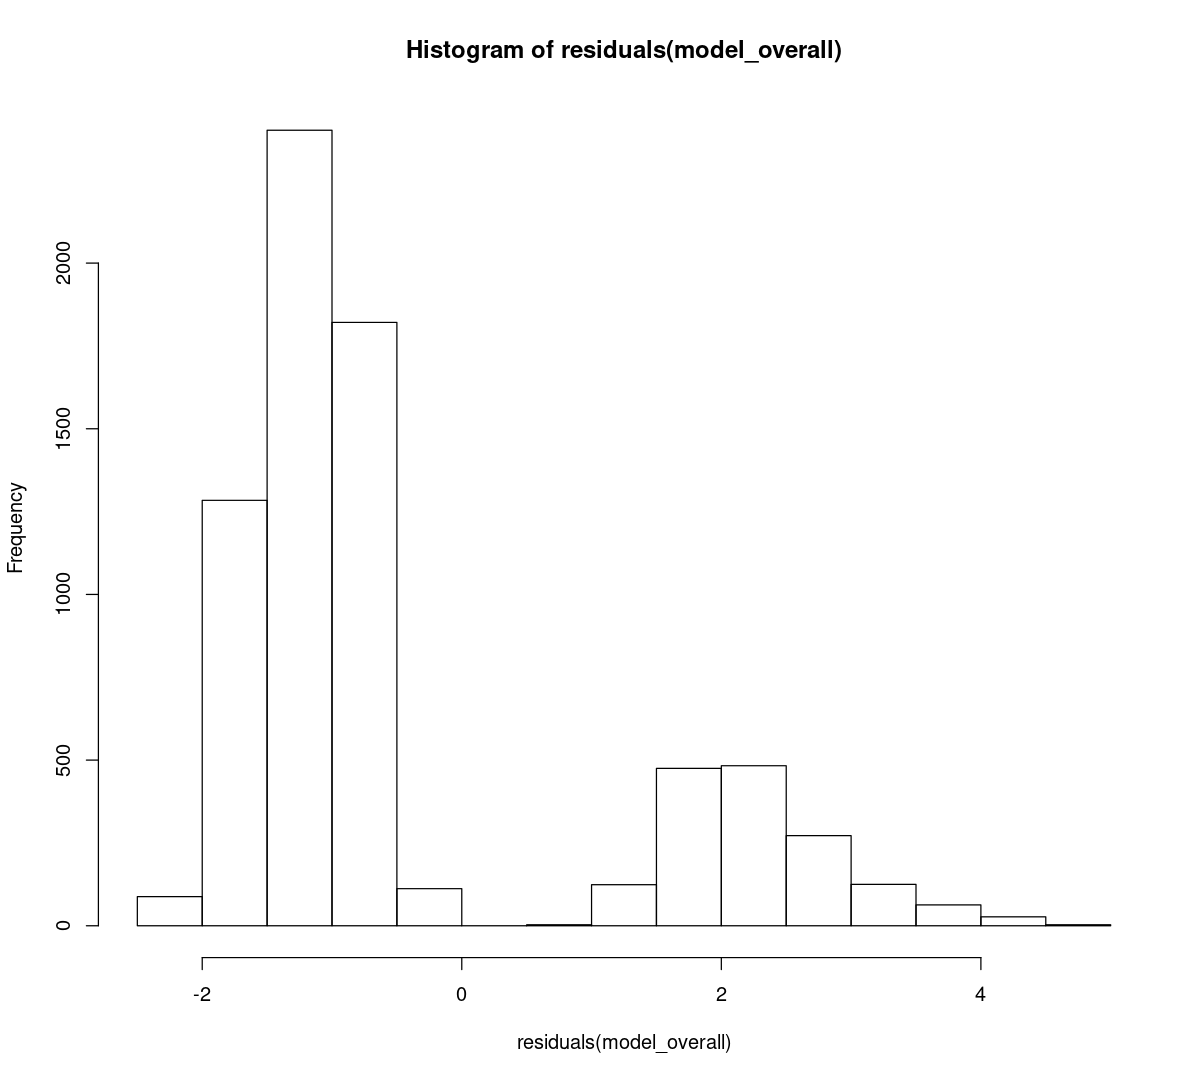

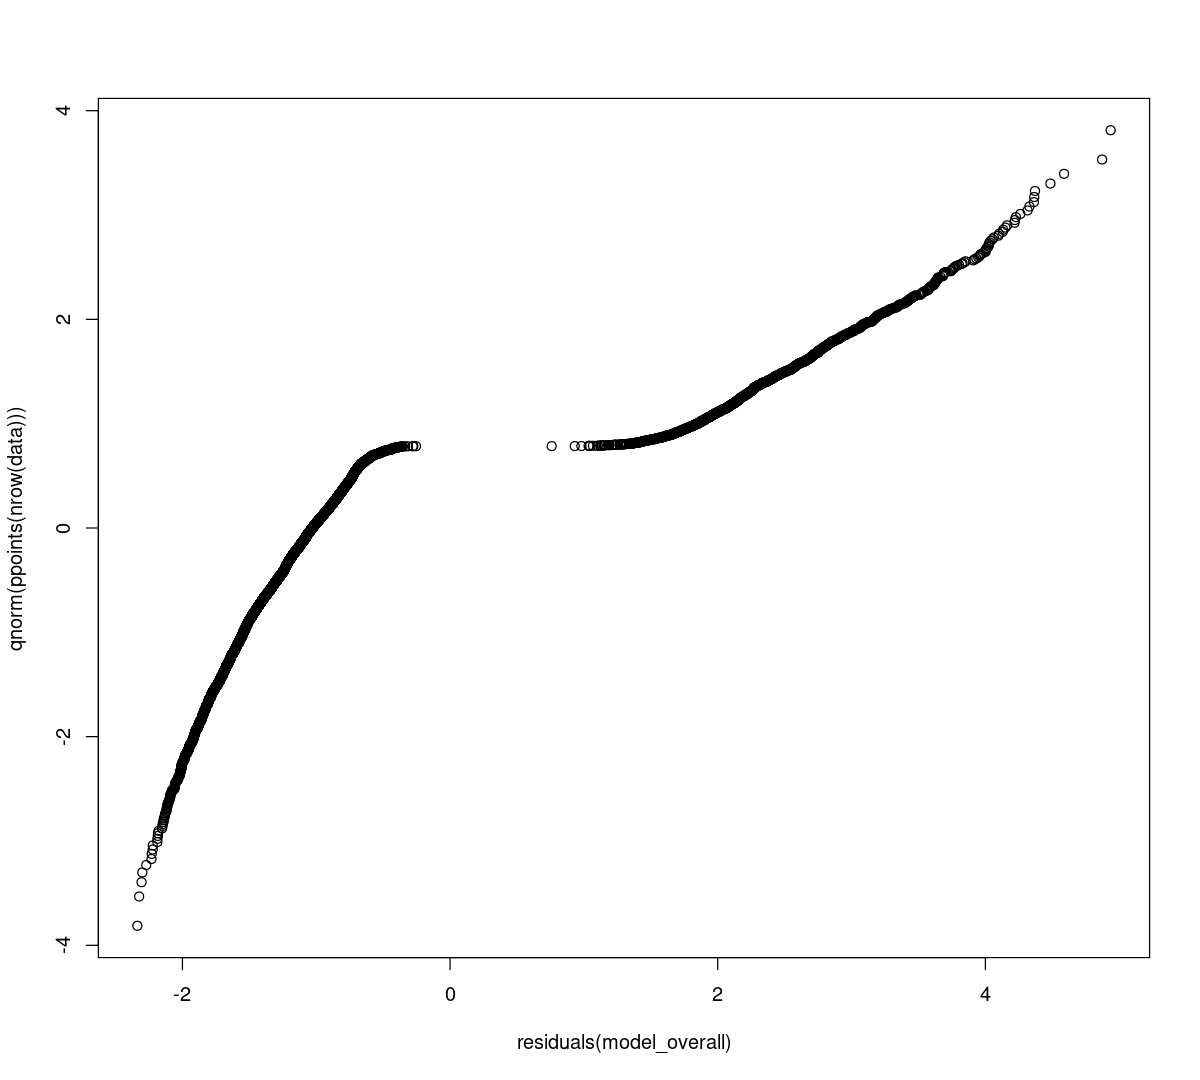

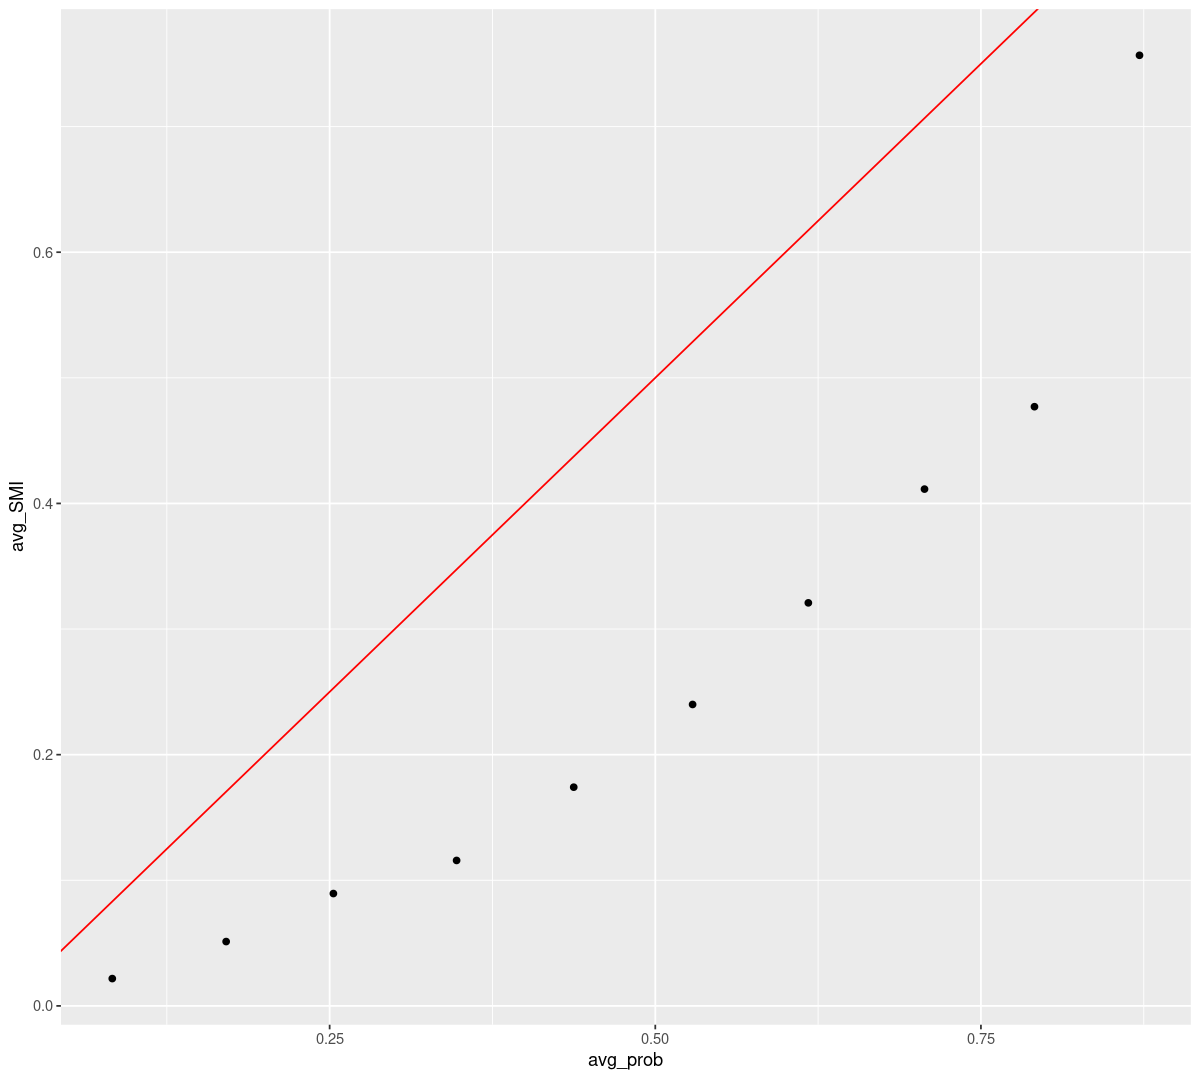

In [23]:
#     + Get a sense of goodness of fit and residuals for this overall model (we may not need this, but might as well do it)

# Histogram of residuals
hist(residuals(model_overall))

# Q-Q plot
qqplot(residuals(model_overall), qnorm(ppoints(nrow(data))))

# Calibration
data$probs = probs
# tb_df$prob_grp = ceiling(order(tb_df$probs)/135) 
data$prob_grp = cut(data$probs, 10)
calibration_df = data %>% 
  group_by(prob_grp) %>%
  summarize(avg_SMI = mean(signs_of_mental_illness=='True'), avg_prob = mean(probs))

ggplot(calibration_df) + geom_point(aes(x=avg_prob, y=avg_SMI)) +
  geom_abline(aes(slope=1, intercept=0), col="red")

The diagnostic plots for our model are not as clean as we'd like them to be - a Q-Q plot and histogram of residuals do not quite show the normality we'd like to see. The histogram of residuals specifically shows our residuals are bimodal, appearing to show a relatively normal distribution on either side of zero. Our model is well-calibrated for the first seven or eight of ten buckets, but does on average assigns lower probability of signs of mental illness to points where that average is actually higher.

In [24]:
#  2. Once this final model has been decided, split the data into batches by year, and fit the model to each batch individually
#     + Compare coefficients of fitted models across batches to interpret how things are changing/staying the same over time
#     + Also check goodness of fit and residuals for each batch

data = data %>% mutate(yr = year(date))
data$rw = response_weights
aggregate(data$yr, by=list(data$yr), FUN=length)

Group.1,x
<dbl>,<int>
2015,994
2016,958
2017,980
2018,985
2019,999
2020,1020
2021,1051
2022,294


In [25]:
# Splitting into batches

batch_features_to_keep = c("armed","age","gender","race","state","flee","body_camera","signs_of_mental_illness")

batch_1 = data[data$yr %in% c(2015, 2016), ]
batch_1 = batch_1[, (names(batch_1) %in% batch_features_to_keep)]


batch_2 = data[data$yr %in% c(2017, 2018), ]
batch_2 = batch_2[, (names(batch_2) %in% batch_features_to_keep)]

batch_3 = data[data$yr %in% c(2019, 2020), ]
batch_3 = batch_3[, (names(batch_3) %in% batch_features_to_keep)]

batch_4 = data[data$yr %in% c(2021, 2022), ]
batch_4 = batch_4[, (names(batch_4) %in% batch_features_to_keep)]

In [26]:
get_pos_weight <- function(smi) {
    pos_count = length(smi[smi == 'True'])
    return (pos_count/(length(smi)))
}


length(batch_1$signs_of_mental_illness[batch_1$signs_of_mental_illness == 'True'])
length(batch_1$signs_of_mental_illness[batch_1$signs_of_mental_illness == 'False'])

[1] 508

[1] 1444

In [174]:
# Fitting models

""
"THIS IS NOT CONVERGING WITH WEIGHTS, SO CURRENTLY RUN WITHOUT WEIGHTS"
""
pos_wt = get_pos_weight(batch_1$signs_of_mental_illness)
neg_wt = 1 - pos_wt
b1_weights <- ifelse(batch_1$signs_of_mental_illness == 'True', 1/pos_wt, 1/neg_wt)


model1 <- glmer(signs_of_mental_illness ~ armed + age + gender + race + flee + body_camera + (1|state), 
            data=batch_1, family="binomial")

[1] ""

[1] "THIS IS NOT CONVERGING WITH WEIGHTS, SO CURRENTLY RUN WITHOUT WEIGHTS"

[1] ""

In [28]:
""
"THIS IS NOT CONVERGING WITH WEIGHTS, SO CURRENTLY RUN WITHOUT WEIGHTS"
""
pos_wt = get_pos_weight(batch_2$signs_of_mental_illness)
neg_wt = 1 - pos_wt
b2_weights <- ifelse(batch_2$signs_of_mental_illness == 'True', 1/pos_wt, 1/neg_wt)

model2 <- glmer(signs_of_mental_illness ~ armed + age + gender + race + flee + body_camera + (1|state), 
            data=batch_2, family="binomial")

[1] ""

[1] "THIS IS NOT CONVERGING WITH WEIGHTS, SO CURRENTLY RUN WITHOUT WEIGHTS"

[1] ""

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.0294407 (tol = 0.002, component 1)”


In [29]:
""
"THIS IS NOT CONVERGING at all"
""
pos_wt = get_pos_weight(batch_3$signs_of_mental_illness)
neg_wt = 1 - pos_wt
b3_weights <- ifelse(batch_3$signs_of_mental_illness == 'True', 1/pos_wt, 1/neg_wt)

model3 <- glmer(signs_of_mental_illness ~ armed + age + gender + race + flee + body_camera + (1|state), 
            data=batch_3, family="binomial")

[1] ""

[1] "THIS IS NOT CONVERGING at all"

[1] ""

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00483409 (tol = 0.002, component 1)”


In [30]:
""
"THIS IS NOT CONVERGING WITH WEIGHTS, SO CURRENTLY RUN WITHOUT WEIGHTS"
""
pos_wt = get_pos_weight(batch_4$signs_of_mental_illness)
neg_wt = 1 - pos_wt
b4_weights <- ifelse(batch_4$signs_of_mental_illness == 'True', 1/pos_wt, 1/neg_wt)

model4 <- glmer(signs_of_mental_illness ~ armed + age + gender + race + flee + body_camera + (1|state), 
            data=batch_4, family="binomial")

[1] ""

[1] "THIS IS NOT CONVERGING WITH WEIGHTS, SO CURRENTLY RUN WITHOUT WEIGHTS"

[1] ""

In [175]:
# Pulling coefficients and intercepts -> will take some manipulation, but should be doable
mod1_coef_df = coef(model1)["state"]$state
mod2_coef_df = coef(model2)["state"]$state
mod3_coef_df = coef(model3)["state"]$state
mod4_coef_df = coef(model4)["state"]$state

In [176]:
coef(model1)["state"]$state

,(Intercept),armedknife,armedother,armedunarmed,armedundetermined,armedvehicle,age,genderM,raceH,raceO,raceW,fleeFoot,fleeMissing,fleeNot fleeing,fleeOther,body_cameraTrue
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AK,-2.436927,0.6128357,0.5557271,0.04756525,-1.180968,0.4403371,0.005606426,-0.691097,0.3594738,0.6502714,0.9206761,0.1038917,-0.2861543,1.248669,-0.3118732,0.06162823
AL,-2.384325,0.6128357,0.5557271,0.04756525,-1.180968,0.4403371,0.005606426,-0.691097,0.3594738,0.6502714,0.9206761,0.1038917,-0.2861543,1.248669,-0.3118732,0.06162823
AR,-2.461036,0.6128357,0.5557271,0.04756525,-1.180968,0.4403371,0.005606426,-0.691097,0.3594738,0.6502714,0.9206761,0.1038917,-0.2861543,1.248669,-0.3118732,0.06162823
AZ,-2.361916,0.6128357,0.5557271,0.04756525,-1.180968,0.4403371,0.005606426,-0.691097,0.3594738,0.6502714,0.9206761,0.1038917,-0.2861543,1.248669,-0.3118732,0.06162823
CA,-2.371913,0.6128357,0.5557271,0.04756525,-1.180968,0.4403371,0.005606426,-0.691097,0.3594738,0.6502714,0.9206761,0.1038917,-0.2861543,1.248669,-0.3118732,0.06162823
CO,-2.500514,0.6128357,0.5557271,0.04756525,-1.180968,0.4403371,0.005606426,-0.691097,0.3594738,0.6502714,0.9206761,0.1038917,-0.2861543,1.248669,-0.3118732,0.06162823
CT,-2.367492,0.6128357,0.5557271,0.04756525,-1.180968,0.4403371,0.005606426,-0.691097,0.3594738,0.6502714,0.9206761,0.1038917,-0.2861543,1.248669,-0.3118732,0.06162823
DC,-2.360329,0.6128357,0.5557271,0.04756525,-1.180968,0.4403371,0.005606426,-0.691097,0.3594738,0.6502714,0.9206761,0.1038917,-0.2861543,1.248669,-0.3118732,0.06162823
DE,-2.371377,0.6128357,0.5557271,0.04756525,-1.180968,0.4403371,0.005606426,-0.691097,0.3594738,0.6502714,0.9206761,0.1038917,-0.2861543,1.248669,-0.3118732,0.06162823


In [182]:
# Creating dataframe of intercepts for each state

b1_15_16 = mod1_coef_df[1]
b1_15_16["state"] = row.names(b1_15_16)
colnames(b1_15_16)[1] <- 16
b2_17_18 = mod2_coef_df[1]
b2_17_18["state"] = row.names(b2_17_18)
colnames(b2_17_18)[1] <- 18
b3_19_20 = mod3_coef_df[1]
b3_19_20["state"] = row.names(b3_19_20)
colnames(b3_19_20)[1] <- 20
b3_21_22 = mod4_coef_df[1]
b3_21_22["state"] = row.names(b3_21_22)
colnames(b3_21_22)[1] <- 22


state_intercepts = merge(b1_15_16, b2_17_18, by = "state", all = TRUE)
state_intercepts = merge(state_intercepts, b3_19_20, by = "state", all = TRUE)
state_intercepts = merge(state_intercepts, b3_21_22, by = "state", all = TRUE)

# RI does not have any shootings in batch 3
t(state_intercepts)

state,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,⋯,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
16,-2.436927,-2.384325,-2.461036,-2.361916,-2.371913,-2.500514,-2.367492,-2.360329,-2.371377,-2.366826,⋯,-2.331882,-2.442830,-2.386100,-2.306887,-2.240098,-2.376857,-2.118283,-2.366703,-2.431521,-2.391050
18,-3.227066,-3.280982,-3.495782,-3.609338,-3.031211,-3.479078,-3.181332,-3.224603,-3.162901,-2.635243,⋯,-3.071845,-2.906184,-3.390009,-3.052826,-3.056021,-2.943151,-2.921738,-3.015478,-3.118391,-3.055671
20,-2.800660,-2.726718,-2.756582,-2.845528,-2.837950,-2.892509,-2.766439,-2.796765,-2.768780,-2.750274,⋯,-2.788828,-2.861376,-2.820050,-2.826442,-2.812517,-2.791225,-2.688974,-2.813227,-2.828231,-2.783155
22,-2.617661,-2.587248,-2.660324,-2.679024,-2.711311,-2.575371,-2.593256,-2.601900,-2.593783,-2.617698,⋯,-2.564186,-2.485433,-2.420710,-2.644094,-2.528493,-2.584468,-2.678967,-2.549457,-2.615785,-2.556145


In [184]:
# Separate the random effects from the overall intercepts
state_intercepts[,2] = state_intercepts[,2] - mean(state_intercepts[,2], na.rm=TRUE)
state_intercepts[,3] = state_intercepts[,3] - mean(state_intercepts[,3], na.rm=TRUE)
state_intercepts[,4] = state_intercepts[,4] - mean(state_intercepts[,4], na.rm=TRUE)
state_intercepts[,5] = state_intercepts[,5] - mean(state_intercepts[,5], na.rm=TRUE)

In [186]:
# Convert data from wide to long
Molten <- melt(state_intercepts, id.vars = "state")
head(Molten)
Molten$variable = as.numeric(Molten$variable)
Molten$value = as.numeric(Molten$value)

,state,variable,value
,<chr>,<fct>,<dbl>
1,AK,16,-0.062962692
2,AL,16,-0.010360806
3,AR,16,-0.087071907
4,AZ,16,0.012047942
5,CA,16,0.002050757
6,CO,16,-0.126550247


Warning message:
“Removed 1 rows containing missing values (geom_point).”


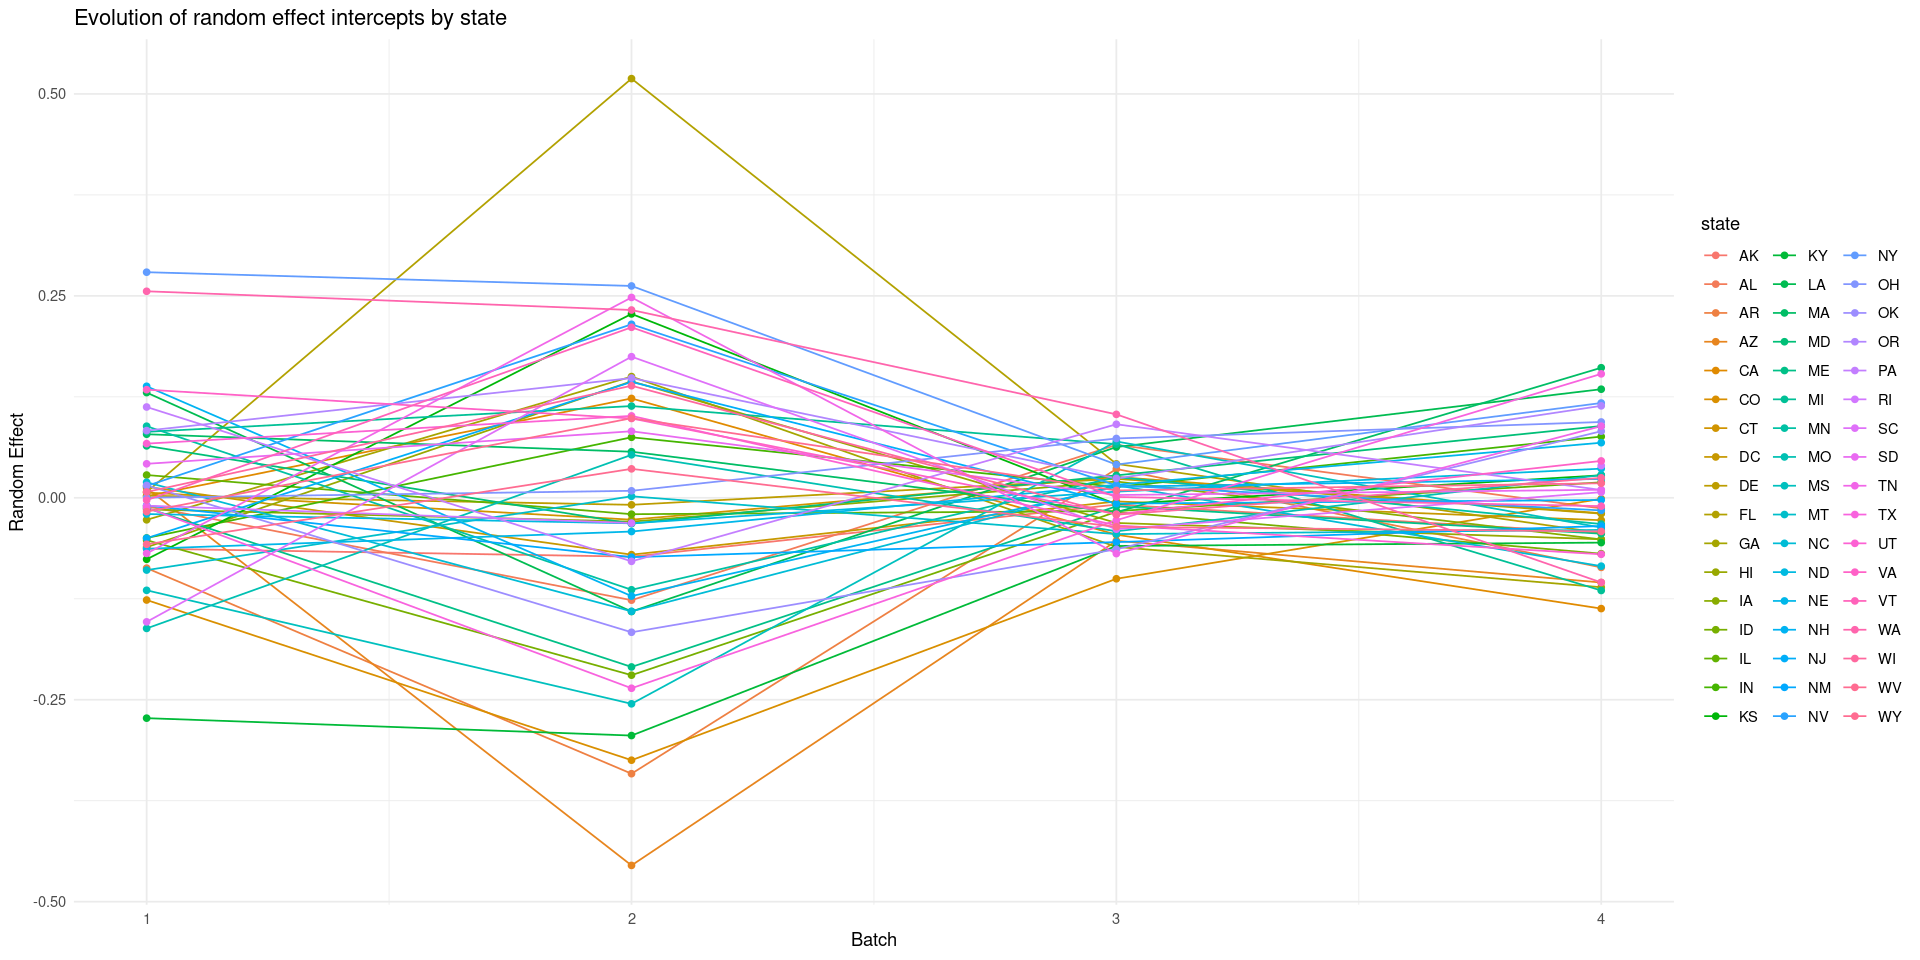

In [187]:
options(repr.plot.width=16, repr.plot.height=8)
ggplot(data=Molten,
       aes(x=variable, y=value, colour=state)) +
       geom_line() + geom_point() + theme_minimal() +
       xlab("Batch") +
       ylab("Random Effect") +
       ggtitle("Evolution of random effect intercepts by state")


In [127]:
# Now looking at other coefficients
coeffs_df = mod1_coef_df[1, 2:dim(mod1_coef_df)[2]]
r2 = mod2_coef_df[1, 2:dim(mod1_coef_df)[2]]
r3 = mod3_coef_df[1, 2:dim(mod1_coef_df)[2]]
r4 = mod4_coef_df[1, 2:dim(mod1_coef_df)[2]]


In [128]:
coeffs_df[nrow(coeffs_df) + 1,] = r2
coeffs_df[nrow(coeffs_df) + 1,] = r3
coeffs_df[nrow(coeffs_df) + 1,] = r4
rownames(coeffs_df) <- c("2016", "2018", "2020", "2022")

In [158]:
coeffs_df$batch = c(2016,2018,2020,2022)
coeffs_df

,armedknife,armedother,armedunarmed,armedundetermined,armedvehicle,age,genderM,raceH,raceO,raceW,fleeFoot,fleeMissing,fleeNot fleeing,fleeOther,body_cameraTrue,batch
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016,0.6128357,0.5557271,0.04756525,-1.1809683,0.4403371,0.005606426,-0.6910970,0.359473790,0.6502714,0.9206761,0.1038917,-0.2861543,1.2486690,-0.3118732,0.06162823,2016
2018,0.7676115,0.3037814,0.07808950,0.5214963,-0.8195071,0.011637985,-0.2530557,0.032725460,0.1226164,0.5943527,0.5204075,0.6507527,1.4808133,0.8350188,0.66059775,2018
2020,0.6398214,0.7775087,0.14731781,-1.9211766,-1.7116200,0.015520640,-0.5783904,-0.005177926,0.4918716,0.7968648,0.3565880,0.5551037,0.9961711,-0.9422848,0.61364567,2020
2022,0.5878407,0.5699425,0.43255558,0.2391071,-1.0251212,0.004299510,-0.6073482,-0.575091628,-0.2571162,0.1545957,0.4523664,0.9275224,1.3622269,0.3559725,0.31598174,2022


In [ ]:
coeffs_to_keep = names(coeffs_df)
coeffs_df = coeffs_df[, (names(coeffs_df) %in% coeffs_to_keep)]

In [164]:
# Convert data from wide to long

Molten_C <- melt(coeffs_df, id.vars = "batch")
head(Molten_C)
Molten_C$variable = as.factor(Molten_C$variable)
Molten_C$batch = as.numeric(Molten_C$batch)
Molten_C$value = as.numeric(Molten_C$value)

,batch,variable,value
,<dbl>,<fct>,<dbl>
1,2016,armedknife,0.6128357
2,2018,armedknife,0.7676115
3,2020,armedknife,0.6398214
4,2022,armedknife,0.5878407
5,2016,armedother,0.5557271
6,2018,armedother,0.3037814


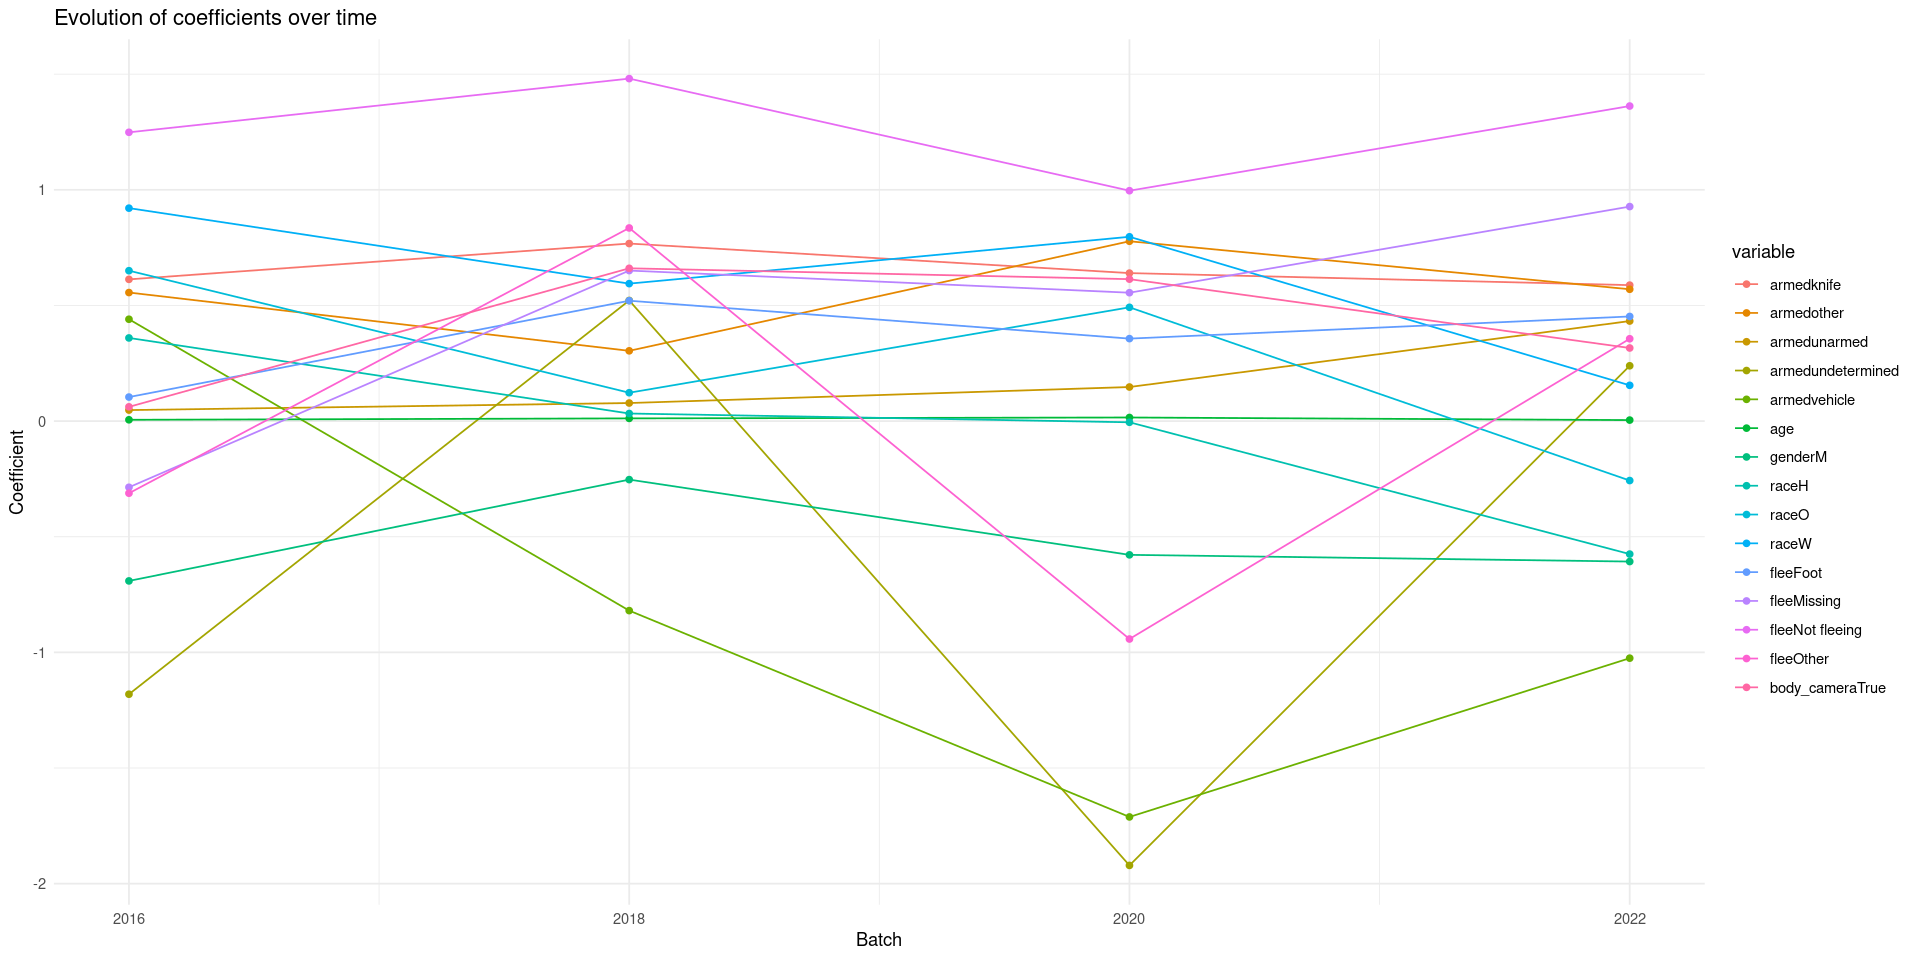

In [165]:
options(repr.plot.width=16, repr.plot.height=8)
ggplot(data=Molten_C,
       aes(x=batch, y=value, colour=variable)) +
       geom_line() + geom_point() + theme_minimal() +
       xlab("Batch") +
       ylab("Coefficient") +
       ggtitle("Evolution of coefficients over time")

In [188]:
write.csv(coeffs_df, "data/coefficients_over_time.csv", row.names = TRUE)
write.csv(state_intercepts, "data/state_intercepts_over_time.csv", row.names = TRUE)